## 3.2 现代卷积神经网络
现代卷积神经网络的研究中下面每一个模型都曾一度占据主导地位，其中许多模型都是ImageNet竞赛的优胜者。ImageNet竞赛自2010年以来，一直是计算机视觉中**监督学习**进展的指向标。其包括:
* LeNet: 最”远古“的神经网络。
* AlexNet。它是第一个在大规模视觉竞赛中击败传统计算机视觉模型的大型神经网络。
* 使用重复块的网络（VGG）。它利用许多重复的神经网络块。
* 网络中的网络（NiN）。它重复使用由卷积层和$1 \times 1$卷积层（用来代替全连接层）来构建深层网络。
* 含并行连结的网络（GoogLeNet）。它使用并行连结的网络，通过不同窗口大小的卷积层和最大池化层来并行抽取信息。
* 残差网络（ResNet）。它通过残差块构建跨层的数据通道，是计算机视觉中最流行的体系架构。
* 稠密连接网络（DenseNet）。它的计算成本很高，但给我们带来了更好的效果。

*温馨提示: 本小节内容较多，读者可根据自己需要来进行阅读。*

### 3.2.1 LeNet
这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像中的手写数字。 当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。
当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。 LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。 时至今日，一些自动取款机仍在运行Yann LeCun和他的同事Leon Bottou在上世纪90年代写的代码。

总体来看，LeNet（LeNet-5）由两个部分组成：
* 卷积编码器：由**两个卷积层**组成
* 全连接层密集块：由**三个全连接层**组成

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均池化层。请注意，虽然ReLU和最大池化层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用$5 \times 5$卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个$2 \times 2$池操作（步骤2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。如下图所示:
![](https://zh-v2.d2l.ai/_images/lenet.svg)

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量(识别0-9的数字)。

下面我们通过Pytorch代码，使用一个Sequential块即可把上面所描述的层全部连接起来。

对原始模型做了一点小改动，去掉了最后一层的高斯激活。

In [4]:
import torch
from torch import nn

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

下面，我们将一个大小为$28 \times 28$的单通道（黑白）图像通过LeNet。通过在每一层打印输出的形状，我们可以检查模型是否与下图保持一致:
![](https://zh-v2.d2l.ai/_images/lenet-vert.svg)

In [5]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


#### 训练模型
下面我们通过训练模型进行实战，我们选取Fashion-MNIST数据集
* Fashion-MNIST: 含有非数字的图片
* 原始MNIST: 只含有数字图片

为了演示方便，同样使用d2l库，并且我的本机环境采用CPU进行训练，但是如果有条件，可以尝试GPU来加快训练。
下面代码在GPU与CPU上均可跑通:

* 加载数据集

In [6]:
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



D:\tensorflow1\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中。

* 计算模型精度

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """ 使用GPU计算模型所在数据集的精度"""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总浏览数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

下面我们开始训练:
我们使用Xavier随机初始化模型参数。 与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。

In [8]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.465, train acc 0.827, test acc 0.828
5740.3 examples/sec on cpu


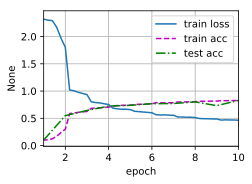

In [9]:
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 3.2.2 AlexNet
AlexNet是我们真正意义上的一个深度卷积神经网络，其发表在2012年的论文 [ImageNet Classification with Deep Convolutional Neural Networks](chrome-extension://ikhdkkncnoglghljlkmcimlnlhkeamad/pdf-viewer/web/viewer.html?file=https%3A%2F%2Fproceedings.neurips.cc%2Fpaper%2F2012%2Ffile%2Fc399862d3b9d6b76c8436e924a68c45b-Paper.pdf) 是深度学习的奠基作之一，其也赢下了当年ImageNet数据集的冠军（1百万个样本，1000种类别）。截止到我写这篇博客(2022年)为知，其引用数已经达到了102838次。论文当中，有些技术细节现在来看或许是多余的，但是其很多工作，对后面的一系列研究起到重要的启发式作用。

## 学习表征
在合理地复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数。
在计算机视觉当中，最底层可能检测边缘，纹理等信息。正如AlexNet论文当中描述的，在底层的网络当中，模型学到了一些类似于传统滤波器的特征抽取器，论文中的图像生动表示了这种底层特征信息，其为AlexNet第一层学习到的特征抽取器:
![](https://zh-v2.d2l.ai/_images/filters.png)


AlexNet的更高层建立在这些底层表示的基础上，以表示更大的特征，如眼睛、鼻子、草叶等等。而更高的层可以检测整个物体，如人、飞机、狗或飞盘。（高层具有更多的**语义信息**）最终的隐藏神经元可以学习图像的综合表示，从而使属于不同类别的数据易于区分。尽管一直有一群执着的研究者不断钻研，试图学习视觉数据的逐级表征，然而很长一段时间里这些尝试都未有突破。深度卷积神经网络的突破出现在2012年。突破可归因于两个关键因素: 数据与硬件计算。

AlexNet论文当中采用的硬件是两块3GB的GTX 580实现卷积运算。但实际上，在今天的硬件水平下，AlexNet做模型并行是有些多余的。但面对当今更大的模型(eg BERT, Transformer)，模型并行又重新流行了起来。

### 网络架构
2012年，AlexNet横空出世。它首次证明了学习到的特征可以超越手工设计的特征。它一举打破了计算机视觉研究的现状。 AlexNet使用了**8层**卷积神经网络，并以很大的优势赢得了2012年ImageNet图像识别挑战赛。下图为其论文中的网络示意图:
![](https://s2.loli.net/2022/02/06/qWFM1EjodptX7ay.png)

为了让读者更容易看懂，我们简化其分开GPU进行训练的设计，其架构如下图所示（左图为LeNet，右图为AlexNet）:
![](https://zh-v2.d2l.ai/_images/alexnet.svg)

**注意**:后续的代码实现亦不会考虑分开GPU来进行训练。

可以看到，AlexNet和LeNet的设计理念非常相似，但也存在显著差异:
* AlexNet比相对较小的LeNet5要深得多。
* AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。
* AlexNet使用ReLU而不是sigmoid作为其激活函数。
* AlexNet十大池化层（LeNet使用平均池化层），并且卷积层有更大的和窗口和步长（因为图片有更大的像素）。
![](https://s2.loli.net/2022/02/07/ehTzgiSsrUdY2Nu.png)
主要的改进为:
* dropout 丢弃法，而不是权重衰减，避免过拟合。（当然，论文中还用到了两种数据增强的方法避免过拟合，随机crop与通道变换）
    * 后面的论文基本解释dropout等价于$l2$正则，但无法用表达式写出来。
* ReLU 取代 sigmoid，更简单更快
* 使用最大池化层 MaxPooling

AlexNet的出现极大的推动了计算机视觉，和有监督学习的发展。

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

下面通过Pytorch API构造AlexNet。这里为了捕捉对象，我们开始使用一个核大小为11的窗口,我们使用MNIST数据集，因此输入通道数为1。

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

测试一下每层的输出:

In [1]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

NameError: name 'torch' is not defined

#### 训练网络
以Fashion-MNIST图像为数据集，其分辨率为$28 \times 28$像素，远低于ImageNet的$224 \times 224$ 为了令其训练成功，我们将其增加到$224 \times 224$（**但实际应用当中，并不建议这样做！**）
为了演示方便，我们借助d2l库的函数完成数据集导入和训练。

* 读取数据集

In [6]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* 训练网络

下面函数支持在GPU和CPU上训练

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """计算模型精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估状态
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量, 预测总数
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调中所使用的，这里不用理会
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [8]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    """模型训练函数"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.327, train acc 0.880, test acc 0.880
384.6 examples/sec on cuda:0


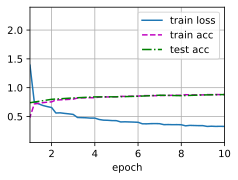

In [20]:
lr, num_epochs = 0.01, 10
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 3.2.3 深度神经网络设计
在AlexNet当中，其设计不太规则，让人感觉比较随意，没有提供一个通用的模板来指导后续的研究人员设计新的网络。 后面将介绍一些常用于设计深层神经网络的启发式概念。

#### VGG 使用块的网络
与芯片设计中工程师从放置晶体管到逻辑元件再到逻辑块的过程类似，神经网络架构的设计也逐渐变得更加抽象。研究人员开始从单个神经元的角度思考问题，发展到整个层，现在又转向块，重复层的模式。

##### VGG块
经典卷积神经网络的基本组成部分是下面的这个序列：
 1. 带填充以保持分辨率的卷积层。
 2. 非线性激活函数，如ReLU。
 3. 汇聚层，如最大汇聚层。

而对VGG块来说:
如何训练更深更大网路：
* 选项
  * 更多的全连接层（太贵）
  * 更多的卷积层
  * **将卷积层组合成块**(VGG核心思想)

一个VGG块由一系列**卷积层**组成，后面再加上用于空间下采样的**最大汇聚层**。

该函数有三个参数，分别对应于卷积层的数量`num_convs`、输入通道的数量`in_channels` 和输出通道的数量`out_channels`。
我们下面[原始论文](https://arxiv.org/abs/1409.1556)中的网络结构:

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

##### VGG网络
VGG网络可以分为两部分：
* 第一部分主要由**卷积层**和**汇聚层**组成
* 第二部分由**全连接层**组成

![](https://zh-v2.d2l.ai/_images/vgg.svg)

其中有超参数变量conv_arch。该变量指定了每个VGG块里卷积层个数和输出通道数。

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

下面的代码实现了VGG-11。可以通过在conv_arch上执行for循环来简单实现。

In [5]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

下面构建一个高度和宽度为224的单通道数据样本，以观察每个层输出的形状。

In [6]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


#### 训练模型
由于VGG-11比AlexNet计算量更大，因此构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。

In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.172, train acc 0.936, test acc 0.923
366.9 examples/sec on cuda:0


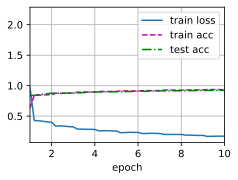

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 3.2.4 NiN块 网络中的网络
`LeNet`、`AlexNet`和`VGG`都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取**空间结构特征**,然后通过**全连接层**对特征的表征进行处理。AlexNet和VGG对LeNet的改进主要在于如何构造一个更深的网络。
然而，如果使用了全连接层，可能会**完全放弃表征**的空间结构，会带来*过拟合*，内存也要求很大。
* 卷积层需要较少的参数

$$
c_i \times c_o \times k^2
$$

* 但卷积后的第一个全连接层的参数：
  * LeNet
    * 16x5x5x120= 48k
  * AlexNet
    * 256x5x5x4096 = 26M
  * VGG
    * 512x7x7x4096= 102M

**NiN的设计思想**: 完全不要全连接层, 使用卷积层来进行替代。在每个像素的通道上分别使用多层感知机。 实际上NiN的使用并不算广泛，但其提出了新的概念。


![](https://zh-v2.d2l.ai/_images/nin.svg)

* 1 $\times$ 1的卷积层（**等价于一个全连接层**）
* 交替使用**NiN块**和步幅为2的**最大池化层**（高宽减半）
  * 逐步减小高宽和增大通道数
* 最后使用全局平均池化层得到输出
  * 其（最后一层）输入通道数是类别数（每个通道拿出一个值）

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

#### NiN块代码实现

In [3]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

#### NiN模型代码实现

In [4]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),  # 10个类别
    nn.AdaptiveAvgPool2d((1, 1)),  # 全局平均池化层，池化后的每个通道上的大小是一个1x1
    nn.Flatten()  # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
)

In [5]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


#### 训练

loss 0.349, train acc 0.869, test acc 0.863
379.2 examples/sec on cuda:0


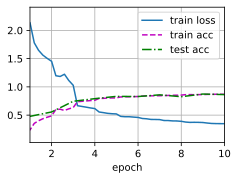

In [6]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())